Plate detection and recognition

In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [49]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show_image(img):
    plt.imshow(img, 'gray')

Prosecna visina: 89.08
Prosecna sirina: 287.82
Prosecan aspect ratio: 3.25


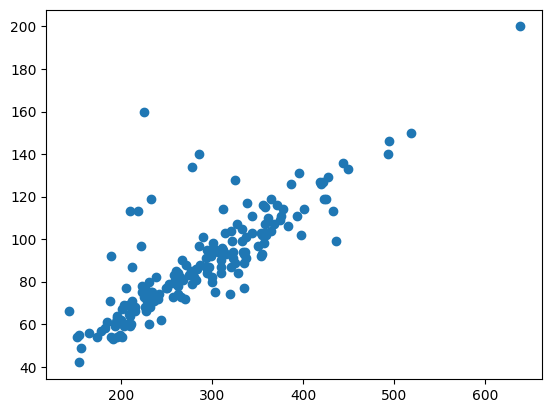

In [50]:
positive_images = []
negative_images = []

folder_path = '../datasets/train/'

aspect_ratios = []
widths = []
heights = []

for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = load_image(img_path)
    if 'plate' in img_name:
        positive_images.append(img)
        width = img.shape[1]
        height = img.shape[0]
        heights.append(height)
        widths.append(width)
        aspect_ratios.append(width/height)

    elif 'neg' in img_name:
        negative_images.append(img)

print(f'Prosecna visina: {sum(heights)/len(positive_images):.2f}')
print(f'Prosecna sirina: {sum(widths)/len(positive_images):.2f}')
avg_aspect_ratio = sum(aspect_ratios) / len(aspect_ratios)
print(f'Prosecan aspect ratio: {avg_aspect_ratio:.2f}')
plt.scatter(widths, heights)
plt.show()


In [51]:
new_width = 200
new_height = int(new_width / avg_aspect_ratio)

for i, img in enumerate(positive_images):
    positive_images[i] = cv2.resize(img, (new_width, new_height))

for i, img in enumerate(negative_images):
    negative_images[i] = cv2.resize(img, (new_width, new_height))


In [52]:
positive_features = []
negative_features = []
labels = []

nbins = 9
cell_size = (8, 8)
block_size = (3, 3)

hog = cv2.HOGDescriptor(_winSize=(new_width // cell_size[1] * cell_size[1], 
                                  new_height // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

for img in positive_images:
    positive_features.append(hog.compute(img))
    labels.append(1)

for img in negative_images:
    negative_features.append(hog.compute(img))
    labels.append(0)

positive_features = np.array(positive_features)
negative_features = np.array(negative_features)
x = np.vstack((positive_features, negative_features))
y = np.array(labels)

In [53]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)

y_train_pred = svm.predict(x_train)
y_val_pred = svm.predict(x_val)
print(f'Train accuracy:{accuracy_score(y_train, y_train_pred)}')
print(f'Validation accuracy:{accuracy_score(y_val, y_val_pred)}')


Train accuracy:1.0
Validation accuracy:0.9857142857142858


In [54]:
def evaluate_window(window):
    features = hog.compute(window).reshape(1, -1)
    return svm.predict_proba(features)[0][1]

In [55]:
def detectPlate(image, step, window_size):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = evaluate_window(window)
                if score > best_score:
                    best_score = score
                    best_window = (y, x)
    return best_score, best_window


In [117]:
# def detectPlate2(image, step, window_size):
#     scores = []
#     windows = []
#     for y in range(0, image.shape[0], step):
#         for x in range(0, image.shape[1], step):
#             window = image[y:y+window_size[1], x:x+window_size[0]]
#             if window.shape == (window_size[1], window_size[0]):
#                 score = evaluate_window(window)
#                 scores.append(score)
#                 windows.append((y, x))
#     return scores, windows

In [ ]:
# def non_maxima_suppression(boxes, scores, threshold):
    
#     boxes = np.array(boxes)

#     # lower left coordinate of the BBox
#     x1 = boxes[:, 0]
#     y1 = boxes[:, 1]
#     # upper right coordinate of the BBox
#     x2 = boxes[:, 2]
#     y2 = boxes[:, 3]

#     area = (x2 - x1 + 1) * (y2 - y1 + 1)
#     idxs = np.argsort(scores)
#     pick = []

#     while len(idxs) > 0:
#         last = len(idxs) - 1
#         i = idxs[-1]
#         pick.append(i)

#         xx1 = np.maximum(x1[i], x1[idxs[:last]])
#         yy1 = np.maximum(y1[i], y1[idxs[:last]])
#         xx2 = np.minimum(x2[i], x2[idxs[:last]])
#         yy2 = np.minimum(y2[i], y2[idxs[:last]])

#         w = np.maximum(0, xx2 - xx1 + 1)
#         h = np.maximum(0, yy2 - yy1 + 1)

#         overlap = (w * h) / area[idxs[:last]]

#         idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))

#     return pick

In [ ]:
# images = gaussian_pyramid(img)

# for img in images:  
#     boxes2 = []
#     scores, boxes = detectPlate2(img, 15, (new_width, new_height))
#     for window in boxes:
#         y, x = window
#         x2 = x + new_width
#         y2 = y + new_height
#         window2 = (x, y, x2, y2)
#         boxes2.append(window2)
#     pick = non_maxima_suppression(boxes2, scores, 0.1)
#     i = pick[0]
#     print(scores[i])
#     rect = plt.Rectangle((boxes[i][1], boxes[i][0]), new_width, new_height, edgecolor='r', facecolor='none')
#     plt.imshow(img, cmap='gray')
#     plt.gca().add_patch(rect)
#     plt.show()


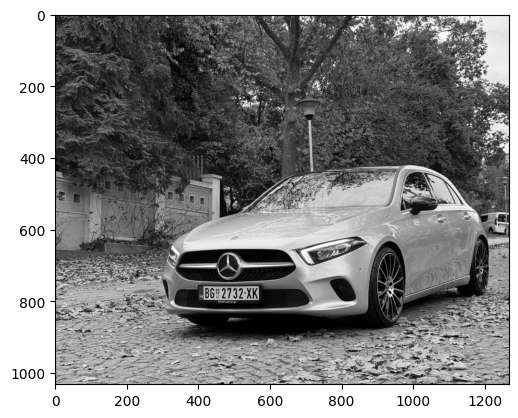

In [145]:
img = load_image('/home/stefan/Downloads/test4.jpg')
show_image(img)

necemo koristiti cv2.pyrDown(image)


In [98]:
def gaussian_pyramid(image, num_levels=3, ksize=(5,5)):
    images = []
    images.append(image)

    for i in range(num_levels-1):
        image = cv2.GaussianBlur(image, sigmaX=0, ksize=ksize)
        width = int(image.shape[1] / 1.3)
        height = int(image.shape[0] / 1.3)
        image = cv2.resize(image, (width, height))
        images.append(image)

    return images

0.9818642338457662


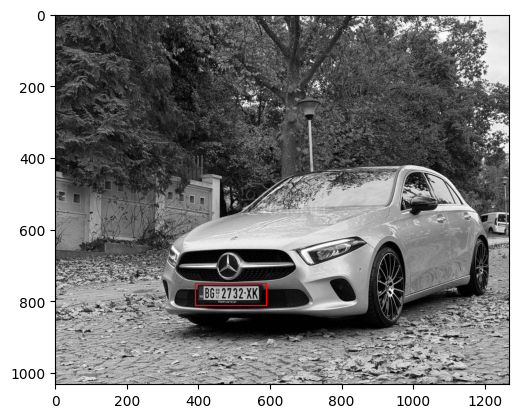

0.9080275558577138


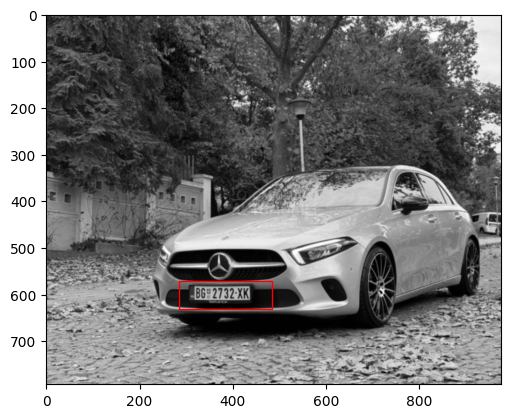

0.5416752716591768


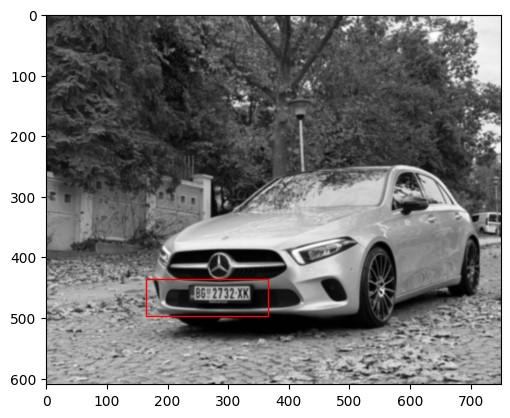

0.5614724232059165


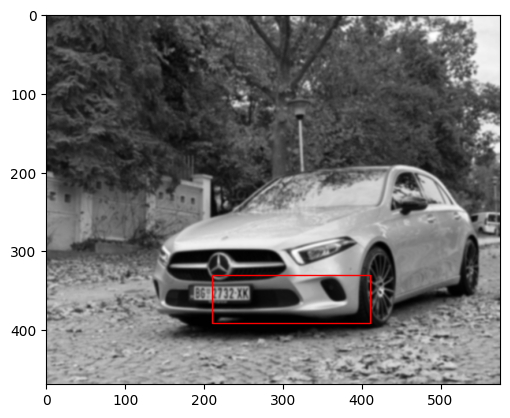

0.10733953418951721


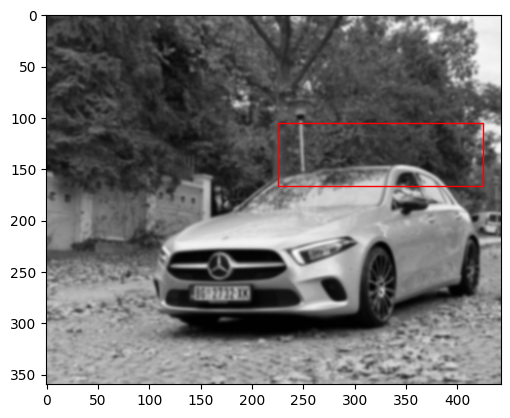

In [146]:
images = gaussian_pyramid(img, num_levels=5)
boxes = []
scores = []
for img in images:  
    score, window = detectPlate(img, 15, (new_width, new_height))
    y, x = window
    x2 = x + new_width
    y2 = y + new_height
    window2 = (x, y, x2, y2)
    scores.append(score)
    boxes.append(window2)
    print(score)
    rect = plt.Rectangle((x, y), new_width, new_height, edgecolor='r', facecolor='none')
    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(rect)
    plt.show()
